In [1]:
pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


--

Environment Description

CartPole-v1 : https://gymnasium.farama.org/environments/classic_control/cart_pole/

Acrobot-v1 : https://gymnasium.farama.org/environments/classic_control/acrobot/

MountainCar-v0 : https://gymnasium.farama.org/environments/classic_control/mountain_car/

--

In [161]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")



---



## 1. DQN Implemetation

In [162]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # input  : (b_size, state_dim)
        self.fc1 = nn.Linear(state_dim, 512)
        self.fc2 = nn.Linear(512, action_dim)
        # output : (b_size, action_dim)

    def forward(self, s):
        x = F.relu(self.fc1(s))
        q = self.fc2(x)
        return q

In [173]:
class DQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size         = state_size
        self.action_size        = action_size
        self.device             = device

        # Do not modify these hyper-parameters
        self.Epochs             = 1000
        self.discount_factor    = 0.98
        self.learning_rate      = 0.001  # learning rate for q function
        self.epsilon            = 1.0    # initial epsilon value
        self.epsilon_min        = 0.001  # minimum epsilon value
        self.batch_size         = 256
        self.train_start        = self.batch_size * 5
        self.memory             = deque(maxlen=100000)  # replay memory

        # You can modify this depending on environments.
        self.epsilon_decay_rate = 0.995 # decay rate

        # Define and initialize your networks and optimizer
        self.q_network          = QNetwork(state_size, action_size).to(device)
        self.target_network     = QNetwork(state_size, action_size).to(device)
        self.optimizer          = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)

        self.update_target_network()  # copy q network's weight to target network


    def update_target_network(self):
        # implement target Q network update function
        self.target_network.load_state_dict(self.q_network.state_dict()) #bring q_network's weight to target_network
        
    def get_action(self, state, use_epsilon_greedy=True):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        if use_epsilon_greedy:
            
            if np.random.rand() <= self.epsilon:
                action = random.randrange(self.action_size)
                
            else:
                with torch.no_grad():
                    Q_values = self.q_network(state)
                    action = torch.argmax(Q_values).item()
            # implement epsilon greedy policy given state

        else:
            # implement greedy policy given state
            # this greedy policy is used for evaluation
            with torch.no_grad():
                Q_values = self.q_network(state)
                action = torch.argmax(Q_values).item()

        return action
    
    def append_sample(self, state, action, reward, next_state, done):
        # implement storing function given (s,a,r,s',done) into the replay memory.
        self.memory.append((state, action, reward, next_state, done))


    def get_samples(self, n):
        # implement transition random sampling function from the replay memory,

        transitions = random.sample(self.memory, n)
        s_batch, a_batch, r_batch, s_next_batch, done_batch = zip(*transitions)
        # i.e.) s_batch : (batch_size, state_dim)
        return s_batch, a_batch, r_batch, s_next_batch, done_batch

    def epsilon_decay(self):
        # implement epsilon decaying function
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay_rate

    def train(self):
        
        s_batch, a_batch, r_batch, s_next_batch, done_batch = self.get_samples(self.batch_size)
        
        s_batch = torch.FloatTensor(np.stack(s_batch)).to(self.device)
        a_batch = torch.LongTensor(np.array(a_batch, dtype=np.int32)).to(self.device)
        
        r_batch = torch.FloatTensor(np.array(r_batch)).to(self.device)

        s_next_batch = torch.FloatTensor(np.stack(s_next_batch)).to(self.device)
        
        non_terminal_mask = torch.ByteTensor(~np.array(done_batch, dtype=np.bool_)).to(self.device)
        
        
        Q_s_a = self.q_network(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)


        
        next_Q_s_a = self.q_network(s_next_batch).max(1)[0]
        target_Q = r_batch + (self.discount_factor * next_Q_s_a * non_terminal_mask)

       

        # huber loss
       
        loss = F.huber_loss(Q_s_a, target_Q)
        # loss = F.mse_loss(Q_s_a, target_Q.detach())
        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()

        return loss.item()



In [174]:
# Do not modify this cell
def evaluation(env, agent):
    done, episode_score, episode_steps = False, 0.0, 0

    state, _ = env.reset()
    for t in range(env._max_episode_steps):
        action = agent.get_action(state, use_epsilon_greedy=False)
        state_next, reward, done, time_truncation, _ = env.step(action)

        episode_score += reward
        episode_steps += 1

        state = state_next
        if done:
            break

    return episode_score, episode_steps


In [175]:
# experiments envs : "CartPole-v1", "Acrobot-v1", "MountainCar-v0"

env_name          = "CartPole-v1"

In [176]:
# Do not modify this cell

env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:4, action_size:2, max_episode_steps:500, device:cuda 

Epoch:0, Episode_score:13.0, Episode_steps:13, epsilon:0.995
Epoch:10, Episode_score:38.0, Episode_steps:38, epsilon:0.946354579813443
Epoch:20, Episode_score:182.0, Episode_steps:182, epsilon:0.9000874278732445
Epoch:30, Episode_score:90.0, Episode_steps:90, epsilon:0.8560822709551227
Epoch:40, Episode_score:65.0, Episode_steps:65, epsilon:0.8142285204175609
Epoch:50, Episode_score:400.0, Episode_steps:400, epsilon:0.7744209942832988
Epoch:60, Episode_score:121.0, Episode_steps:121, epsilon:0.736559652908221
Epoch:70, Episode_score:90.0, Episode_steps:90, epsilon:0.7005493475733617
Epoch:80, Episode_score:127.0, Episode_steps:127, epsilon:0.6662995813682115
Epoch:90, Episode_score:89.0, Episode_steps:89, epsilon:0.6337242817644086
Epoch:100, Episode_score:115.0, Episode_steps:115, epsilon:0.6027415843082742
Epoch:110, Episode_score:189.0, Episode_steps:189, epsilon:0.5732736268885887
Epoch:120, Episode_score:226.0, Epis

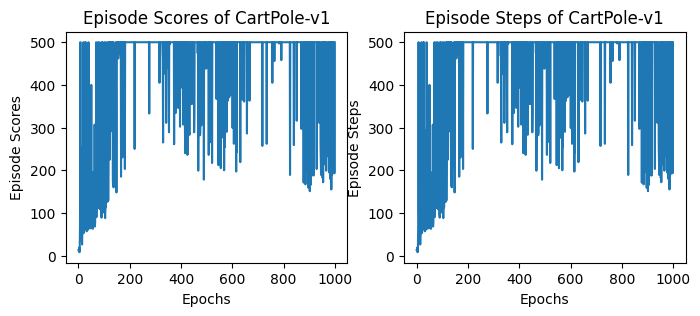

In [177]:
plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(episode_scores_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title("Episode Scores of {}".format(env_name))

plt.subplot(1,2,2)
plt.plot(episode_steps_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title("Episode Steps of {}".format(env_name))

plt.show()



---



## 2. Double DQN implemantation

In [248]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # input  : (b_size, state_dim)
        self.fc1 = nn.Linear(state_dim, 512)
        self.fc2 = nn.Linear(512, action_dim)
        # output : (b_size, action_dim)

    def forward(self, s):
        x = F.relu(self.fc1(s))
        q = self.fc2(x)
        return q

In [249]:
class DoubleDQNAgent:
    def __init__(self, state_size, aciton_size, device):
        self.state_size         = state_size
        self.action_size        = action_size
        self.device             = device

        # Do not modify these hyper-parameters
        self.Epochs             = 1000
        self.discount_factor    = 0.98
        self.learning_rate      = 0.001  # learning rate for q function
        self.epsilon            = 1.0    # initial epsilon value
        self.epsilon_min        = 0.001  # minimum epsilon value
        self.batch_size         = 256
        self.train_start        = self.batch_size * 5
        self.memory             = deque(maxlen=100000)  # replay memory

        # You can modify this depending on environments.
        self.epsilon_decay_rate = 0.995# decay rate

        # Define and initialize your networks and optimizer
        self.q_network          = QNetwork(state_size, action_size).to(device)
        self.target_network     = QNetwork(state_size, action_size).to(device)
        self.optimizer          = optim.AdamW(self.q_network.parameters(), lr=self.learning_rate)




    def update_target_network(self):
        # implement target Q network update function
        self.target_network.load_state_dict(self.q_network.state_dict()) 


    def get_action(self, state, use_epsilon_greedy=True):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        if use_epsilon_greedy:
            
            if np.random.rand() <= self.epsilon:
                action = random.randrange(self.action_size)
                
            else:
                with torch.no_grad():
                    action = self.q_network(state).max(1)[1].item()
            # implement epsilon greedy policy given state

        else:
            # implement greedy policy given state
            # this greedy policy is used for evaluation
            with torch.no_grad():
                action = self.q_network(state).max(1)[1].item()

        return action


    def append_sample(self, state, action, reward, next_state, done):
        # implement storing function given (s,a,r,s',done) into the replay memory.
        self.memory.append((state, action, reward, next_state, done))

    def get_samples(self, n):
        # implement transition random sampling function from the replay memory,
        # and make the transiton to batch.
        samples = random.sample(self.memory, n)
        s_batch, a_batch, r_batch, s_next_batch, done_batch = zip(*samples)


        # i.e.) s_batch : (batch_size, state_dim)
        return s_batch, a_batch, r_batch, s_next_batch, done_batch

    def epsilon_decay(self):
        # implement epsilon decaying function that
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay_rate

    def train(self):
        s_batch, a_batch, r_batch, s_next_batch, done_batch = self.get_samples(self.batch_size)
        
        s_batch = torch.FloatTensor(np.stack(s_batch)).to(self.device)
        a_batch = torch.LongTensor(np.array(a_batch, dtype=np.int32)).to(self.device)
        
        r_batch = torch.FloatTensor(np.array(r_batch)).to(self.device)

        s_next_batch = torch.FloatTensor(np.stack(s_next_batch)).to(self.device)
        
        non_terminal_mask = torch.ByteTensor(~np.array(done_batch, dtype=np.bool_)).to(self.device)
        
        
        Q_s_a = self.q_network(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)

        # Double DQN
        
        next_Q_s_a = self.q_network(s_next_batch).max(1)[1]
        next_Q_value = self.target_network(s_next_batch).gather(1, next_Q_s_a.unsqueeze(1)).squeeze(1)
        target_Q = r_batch + (self.discount_factor * next_Q_value * non_terminal_mask)

       

        # huber loss
        loss = F.huber_loss(Q_s_a, target_Q)

        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()

        return loss.item()
        
        # You can return any statistics you want to check and analyze the training. (i.e. loss, q values, target q values, ... etc)


In [250]:
# Do not modify this cell
def evaluation(env, agent):
    done, episode_score, episode_steps = False, 0.0, 0

    state, _ = env.reset()
    for t in range(env._max_episode_steps):
        action = agent.get_action(state, use_epsilon_greedy=False)
        state_next, reward, done, time_truncation, _ = env.step(action)

        episode_score += reward
        episode_steps += 1

        state = state_next
        if done:
            break

    return episode_score, episode_steps


In [251]:
# experiments envs : "CartPole-v1", "Acrobot-v1", "MountainCar-v0"

env_name          = "MountainCar-v0"

In [252]:
# Do not modify this cell

env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DoubleDQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:2, action_size:3, max_episode_steps:200, device:cuda 

Epoch:0, Episode_score:-200.0, Episode_steps:200, epsilon:0.995
Epoch:10, Episode_score:-200.0, Episode_steps:200, epsilon:0.946354579813443
Epoch:20, Episode_score:-200.0, Episode_steps:200, epsilon:0.9000874278732445
Epoch:30, Episode_score:-200.0, Episode_steps:200, epsilon:0.8560822709551227
Epoch:40, Episode_score:-200.0, Episode_steps:200, epsilon:0.8142285204175609
Epoch:50, Episode_score:-200.0, Episode_steps:200, epsilon:0.7744209942832988
Epoch:60, Episode_score:-200.0, Episode_steps:200, epsilon:0.736559652908221
Epoch:70, Episode_score:-200.0, Episode_steps:200, epsilon:0.7005493475733617
Epoch:80, Episode_score:-200.0, Episode_steps:200, epsilon:0.6662995813682115
Epoch:90, Episode_score:-200.0, Episode_steps:200, epsilon:0.6337242817644086
Epoch:100, Episode_score:-200.0, Episode_steps:200, epsilon:0.6027415843082742
Epoch:110, Episode_score:-200.0, Episode_steps:200, epsilon:0.5732736268885887
Epoch:120, E

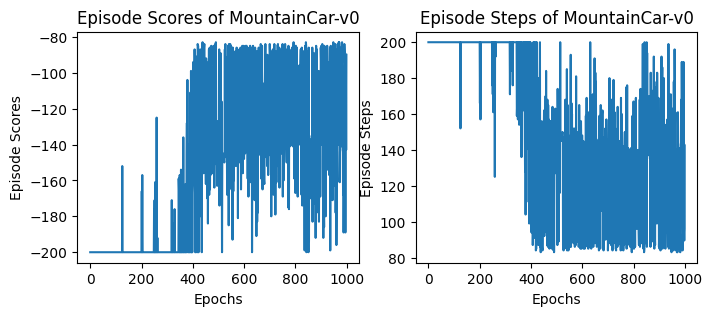

In [253]:
plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(episode_scores_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title("Episode Scores of {}".format(env_name))

plt.subplot(1,2,2)
plt.plot(episode_steps_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title("Episode Steps of {}".format(env_name))

plt.show()



---



## 3. Additional Implementation

In [262]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque



In [269]:

class ActorCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 512)
        self.fc2 = nn.Linear(512, 512)

        # Actor
        self.fc3_actor = nn.Linear(512, action_dim)
        # Critic
        self.fc3_critic = nn.Linear(512, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return x

    def actor(self, x):
        x = self.forward(x)
        return F.softmax(self.fc3_actor(x), dim=-1)

    def critic(self, x):
        x = self.forward(x)
        return self.fc3_critic(x)

In [270]:
class PPOAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size         = state_size
        self.action_size        = action_size
        self.device             = device

        # Hyper-parameters
        self.epochs             = 1000
        self.discount_factor    = 0.99
        self.epsilon            = 0.2
        self.learning_rate      = 0.0003
        self.batch_size         = 64
        self.memory             = deque(maxlen=5000)
        self.update_steps       = 2000

        # Networks
        self.policy_network     = ActorCriticNetwork(state_size, action_size).to(device)
        self.optimizer          = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        probs = self.policy_network.actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample().item()
        return action, dist.log_prob(action)

    def append_sample(self, state, action, reward, next_state, done, log_prob):
        self.memory.append((state, action, reward, next_state, done, log_prob))

    def get_samples(self):
        samples = random.sample(self.memory, self.batch_size)
        s_batch, a_batch, r_batch, s_next_batch, done_batch, log_prob_batch = zip(*samples)
        return s_batch, a_batch, r_batch, s_next_batch, done_batch, log_prob_batch

    def compute_gae(self, rewards, dones, values, next_value):
        gae = 0
        returns = []
        values = values + [next_value]
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.discount_factor * values[step + 1] * (1 - dones[step]) - values[step]
            gae = delta + self.discount_factor * 0.95 * gae
            returns.insert(0, gae + values[step])
        return returns

    def update_policy(self):
        s_batch, a_batch, r_batch, s_next_batch, done_batch, old_log_probs = self.get_samples()

        s_batch = torch.FloatTensor(s_batch).to(self.device)
        a_batch = torch.LongTensor(a_batch).view(-1, 1).to(self.device)
        r_batch = torch.FloatTensor(r_batch).to(self.device)
        s_next_batch = torch.FloatTensor(s_next_batch).to(self.device)
        done_batch = torch.FloatTensor(done_batch).to(self.device)
        old_log_probs = torch.FloatTensor(old_log_probs).to(self.device)

        values = self.policy_network.critic(s_batch).detach().squeeze().tolist()
        next_value = self.policy_network.critic(s_next_batch[-1].unsqueeze(0)).detach().item()
        returns = self.compute_gae(r_batch, done_batch, values, next_value)

        returns = torch.FloatTensor(returns).to(self.device)
        values = torch.FloatTensor(values).to(self.device)
        advantages = returns - values

        for _ in range(4):  # 4 epochs of updates
            for idx in range(0, len(s_batch), self.batch_size):
                sample_idx = np.random.randint(0, len(s_batch), self.batch_size)
                sampled_states = s_batch[sample_idx]
                sampled_actions = a_batch[sample_idx]
                sampled_log_probs = old_log_probs[sample_idx]
                sampled_advantages = advantages[sample_idx]
                sampled_returns = returns[sample_idx]

                # Compute new log probabilities
                probs = self.policy_network.actor(sampled_states)
                dist = torch.distributions.Categorical(probs)
                new_log_probs = dist.log_prob(sampled_actions.squeeze())

                # Compute ratio
                ratio = (new_log_probs - sampled_log_probs).exp()

                # Compute clipped surrogate objective
                surr1 = ratio * sampled_advantages
                surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * sampled_advantages

                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = F.mse_loss(self.policy_network.critic(sampled_states).squeeze(), sampled_returns)

                loss = 0.5 * critic_loss + actor_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def train(self):
        if len(self.memory) < self.update_steps:
            return
        self.update_policy()
        self.memory.clear()


In [271]:
# Do not modify this cell
def evaluation(env, agent):
    done, episode_score, episode_steps = False, 0.0, 0

    state, _ = env.reset()
    for t in range(env._max_episode_steps):
        action = agent.get_action(state, use_epsilon_greedy=False)
        state_next, reward, done, time_truncation, _ = env.step(action)

        episode_score += reward
        episode_steps += 1

        state = state_next
        if done:
            break

    return episode_score, episode_steps


In [272]:
# experiments envs : "CartPole-v1", "Acrobot-v1", "MountainCar-v0"

env_name          = "CartPole-v1"

In [273]:
# Do not modify this cell

env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DoubleDQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:4, action_size:2, max_episode_steps:500, device:cuda 

Epoch:0, Episode_score:8.0, Episode_steps:8, epsilon:0.995
Epoch:10, Episode_score:146.0, Episode_steps:146, epsilon:0.946354579813443
Epoch:20, Episode_score:60.0, Episode_steps:60, epsilon:0.9000874278732445
Epoch:30, Episode_score:280.0, Episode_steps:280, epsilon:0.8560822709551227
Epoch:40, Episode_score:500.0, Episode_steps:500, epsilon:0.8142285204175609
Epoch:50, Episode_score:137.0, Episode_steps:137, epsilon:0.7744209942832988
Epoch:60, Episode_score:110.0, Episode_steps:110, epsilon:0.736559652908221
Epoch:70, Episode_score:129.0, Episode_steps:129, epsilon:0.7005493475733617
Epoch:80, Episode_score:108.0, Episode_steps:108, epsilon:0.6662995813682115
Epoch:90, Episode_score:86.0, Episode_steps:86, epsilon:0.6337242817644086
Epoch:100, Episode_score:94.0, Episode_steps:94, epsilon:0.6027415843082742
Epoch:110, Episode_score:89.0, Episode_steps:89, epsilon:0.5732736268885887
Epoch:120, Episode_score:112.0, Epis

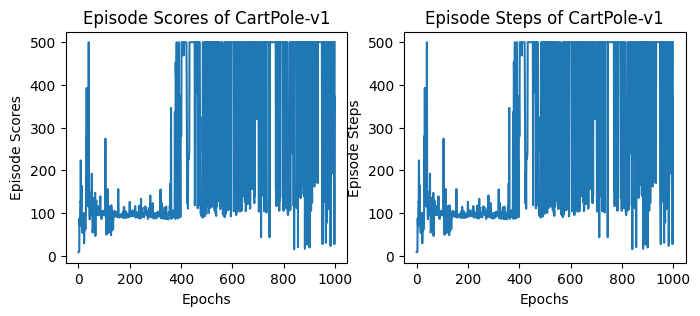

In [275]:
plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(episode_scores_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title("Episode Scores of {}".format(env_name))

plt.subplot(1,2,2)
plt.plot(episode_steps_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title("Episode Steps of {}".format(env_name))

plt.show()